Training data shape: (6002, 13, 1)
Test data shape: (1501, 13, 1)
Number of classes: 6
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6230 - loss: 3.0457 - val_accuracy: 0.9807 - val_loss: 0.0724
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9446 - loss: 0.1747 - val_accuracy: 0.9873 - val_loss: 0.0434
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9518 - loss: 0.1425 - val_accuracy: 0.9907 - val_loss: 0.0366
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9574 - loss: 0.1260 - val_accuracy: 0.9813 - val_loss: 0.0507
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9621 - loss: 0.1087 - val_accuracy: 0.9893 - val_loss: 0.0312
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9699 - loss: 0.0839 - val_accuracy: 0.9927 - val_loss: 0.0258
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9640 - loss: 0.0997 - val_accuracy: 0.9893 - val_loss: 0.0323
Epoch 8/10
188/18

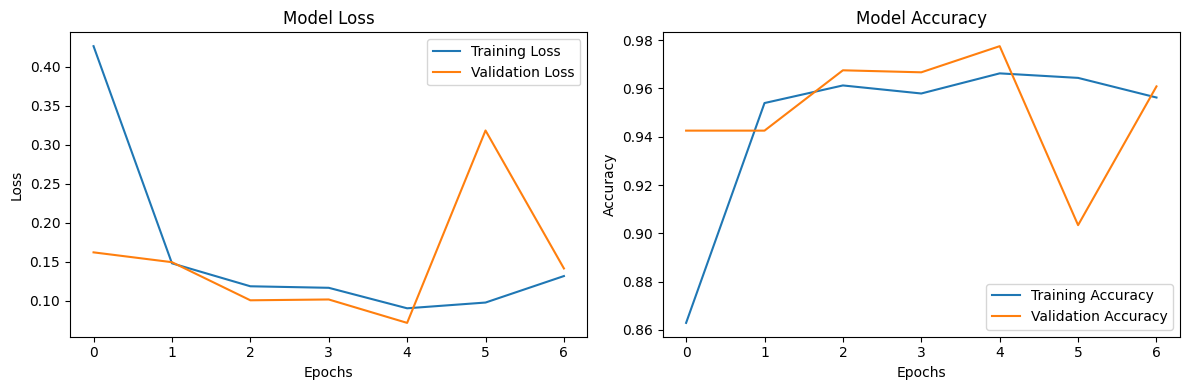

In [5]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Extracting MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=13):
    # Loading audio file
    audio, sample_rate = librosa.load(file_path, sr=None)
    
    # MFCC features extraction
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    
    # Mean of MFCC coefficients over time
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    return mfccs_mean

# Function to process the dataset and extract MFCC features for all audio files
def process_dataset(directory_path):
    mfcc_features = []
    labels = []
    
    # Loop through each speaker directory
    for speaker in os.listdir(directory_path):
        speaker_path = os.path.join(directory_path, speaker)
        
        # Ignore directories like '_background_noise_' and any other irrelevant folders
        if not os.path.isdir(speaker_path) or speaker.startswith('_'):
            continue
        
        # Loop through each audio file in the speaker's folder
        for file_name in os.listdir(speaker_path):
            if file_name.endswith('.wav'):  # Ensure it's a .wav file
                file_path = os.path.join(speaker_path, file_name)
                
                # Extract MFCC features and append to list
                mfcc = extract_mfcc(file_path)
                mfcc_features.append(mfcc)
                
                # Append corresponding label (speaker's name)
                labels.append(speaker)
    
    # Convert lists to a DataFrame
    df = pd.DataFrame(mfcc_features)
    df['label'] = labels
    
    return df

# Define the path to your dataset
dataset_path = "16000_pcm_speeches"  # Change this to your actual dataset path

# Process the dataset to extract MFCC features and labels
df = process_dataset(dataset_path)

# Encode labels (convert to numeric format for the model)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Determine the total number of classes from the unique labels
total_classes = len(label_encoder.classes_)

# Split the data into train and test sets
X = df.drop('label', axis=1)  # Features (MFCCs)
y = df['label']              # Labels (Speakers)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for CNN input
X_train_cnn = X_train.values.reshape(X_train.shape[0], 13, 1)  # 13 MFCC coefficients, 1 channel
X_test_cnn = X_test.values.reshape(X_test.shape[0], 13, 1)

# Convert labels to categorical format with the correct number of classes
y_train_categorical = to_categorical(y_train, num_classes=total_classes)
y_test_categorical = to_categorical(y_test, num_classes=total_classes)

# Print shapes to confirm
print("Training data shape:", X_train_cnn.shape)
print("Test data shape:", X_test_cnn.shape)
print("Number of classes:", total_classes)

# Building the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Convolutional layer
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    
    # Flatten layer
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Adjust output layer to total_classes
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model with the correct number of classes
cnn_model = build_cnn_model((13, 1), total_classes)

# Train the model
cnn_model.fit(X_train_cnn, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_categorical))

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_categorical)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Create subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns, smaller size

# Plot training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
